# ECE1508: Deep Generative Models -- SUM25
## Assignment 1: Text Generation and Language Models
### Programming Part
This assignment reviews fundamental notions in language models, as well as some basic experiment with LLMs, in particular the BERT model. For each task, some explanations have been given and some starter code has been provided. Please complete the provided code and report your observations and conclusions for each part in the provided markdown. For submission, please pay attention to the instructions. Failure to following the instructions can lead to mark deduction.

### How to Answer?
Please complete all parts noted by `#COMPLETE`. Note that these parts are at both __Code__ and __Markdown.__


#### Let's start with loading necessary libraries.

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## Programming Question 1: Basic Context Aware LM
### General Overview
In this question, we implement a basic context aware LM. The architecture is shown below.

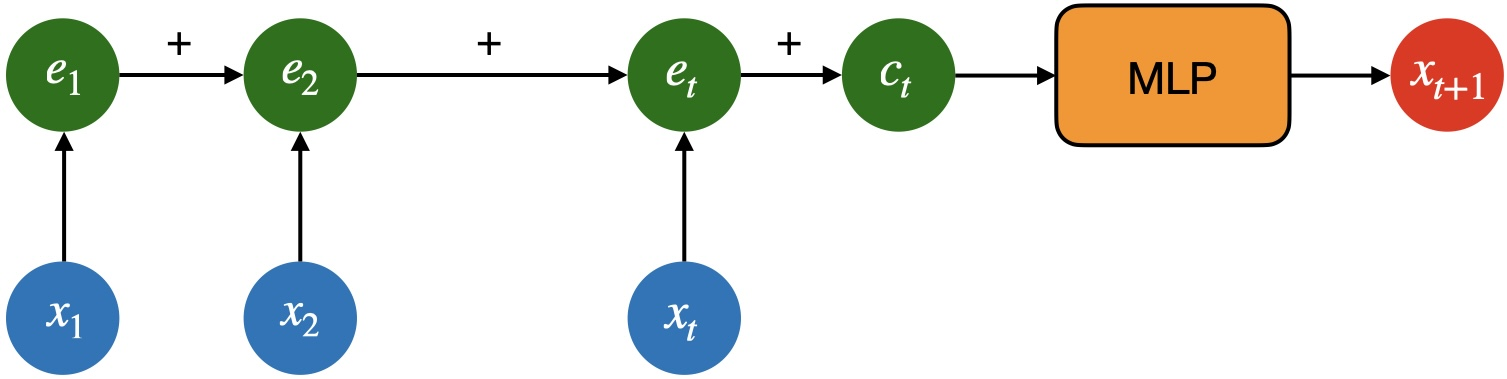

In [ ]:
from IPython.display import Image
Image(filename='Asgn1_Q1.jpeg', width=1100)

As shown in the architecture, to predict the next token, we build a context by __averaging__ the embeddings of all previous tokens, i.e.,

$$
\mathbf{c}_t = \frac{1}{t} \sum_{i=1}^t \mathbf{e}_i
$$

Assuming the embedding size to be `embd_size`, the MLP then use a linear layer to convert the context `c_t` of size `embd_size` to a logit vector of size `vocab_size'. The distribution of the next token is then set to be the softmax of the MLP output.

### Data
We train this model on the attached tiny text file named `corpus.txt`. We first load the corpus as a list of characters named `corpus`.

In [4]:
filename = "corpus.txt"

with open(filename, 'r', encoding='utf-8') as f:
    corpus = list(f.read())
## Read corpus as a list of characters
## Name the read list `corpus`

Let's play around with the corpus to see what there is.

In [6]:
print(len(corpus))
print(corpus[:150])

212623
['L', 'e', 't', "'", 's', ' ', 't', 'r', 'y', ' ', 's', 'o', 'm', 'e', 't', 'h', 'i', 'n', 'g', '.', '\n', 'I', ' ', 'h', 'a', 'v', 'e', ' ', 't', 'o', ' ', 'g', 'o', ' ', 't', 'o', ' ', 's', 'l', 'e', 'e', 'p', '.', '\n', 'T', 'o', 'd', 'a', 'y', ' ', 'i', 's', ' ', 'J', 'u', 'n', 'e', ' ', '1', '8', 't', 'h', ' ', 'a', 'n', 'd', ' ', 'i', 't', ' ', 'i', 's', ' ', 'M', 'u', 'i', 'r', 'i', 'e', 'l', "'", 's', ' ', 'b', 'i', 'r', 't', 'h', 'd', 'a', 'y', '!', '\n', 'M', 'u', 'i', 'r', 'i', 'e', 'l', ' ', 'i', 's', ' ', '2', '0', ' ', 'n', 'o', 'w', '.', '\n', 'T', 'h', 'e', ' ', 'p', 'a', 's', 's', 'w', 'o', 'r', 'd', ' ', 'i', 's', ' ', '"', 'M', 'u', 'i', 'r', 'i', 'e', 'l', '"', '.', '\n', 'I', ' ', 'w', 'i', 'l', 'l', ' ', 'b', 'e', ' ', 'b']


### Tokenization
For tokenization, we use a character level tokenization. This means that each character is a single token. To this end, we make a vocabulary of all available characters in the corpus and implement the `encode` and `decode` functions, which convert a text to index sequence and vice versa.

In [8]:
## make a list including all characters in the corpus
vocab = sorted(list(set(corpus)))
print(len(vocab))  # print the number of characters

# Write encode and decode function
char_to_token = {char:idx for idx,char in enumerate(vocab)}
token_to_char = {idx:char for idx,char in enumerate(vocab)}

# encode converts a text to token indices
encode = lambda s: [char_to_token[c] for c in s]
# decode converts a token sequence to text
decode = lambda t: ''.join([token_to_char[i] for i in t])

84


Let's try an example to confirm the implementation.

In [10]:
text = 'this is the first Assignment!'

# convert to token seq
x = encode(text)
print(x)

# convert back to text
text_dec = decode(x)
print(text_dec)

[69, 57, 58, 68, 1, 58, 68, 1, 69, 57, 54, 1, 55, 58, 67, 68, 69, 1, 25, 68, 68, 58, 56, 63, 62, 54, 63, 69, 2]
this is the first Assignment!


### Implementing LM
We now implement the language model as illustrated in the question. Note that the implementation should take a __batch__ of sample texts as input.

In [12]:
class ContextAwareLM(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(ContextAwareLM, self).__init__()

        # Embedding layer: each embedding is of size (embd_size)
        self.embedding = nn.Embedding(vocab_size, embd_size)

        # Linear layer of MLP of size (embd_size, vocab_size)
        self.MLP = nn.Linear(embd_size, vocab_size)

    def forward(self, x):
        """
        x: Tensor of shape (B, T+1), where B is batch size and T+1 is length of sample.
        """

        # Compute B and T
        B, T_plus_1 = x.size()
        T = T_plus_1 - 1

        # Get token embeddings for input sequence
        embeddings = self.embedding(x)  # Apply Embedding. It should return objects of (B, T+1, embd_size)

        # Compute context at each time t=1,...,T
        ## You may find `torch.stack` useful
        context = torch.stack([embeddings[:, :t, :].mean(dim=1) for t in range(1, T_plus_1)], dim=1)

        # Compute final logits before Softmax
        logits = self.MLP(context)  # (B, T, vocab_size)
        return logits

### Make batch of sequences
We next implement a function that makes a batch of text sequences.

In [14]:
import random

# This function makes a random batch of size B, each sample being of length T
def get_batch(dataset, batch_size, seq_len, device):
    '''
    dataset: encoded text
    batch_size: B
    seq_len: T+1
    device: we will choose "mps", "cuda" or "cpu"
    '''

    # make sure we do not choose a start point with less that T+1 tokens to the end
    max_start = len(dataset) - seq_len - 1

    # initial empty batch
    samples = []

    # make a batch
    for _ in range(batch_size):
        start_idx = random.randint(0, max_start)  # Random start
        seq = dataset[start_idx : start_idx + seq_len + 1]  # Sample of length T+1
        samples.append(seq)  # Append to list

    # convert to Tensor and move to selected device
    x = torch.tensor(samples, dtype=torch.long).to(device=device)  # (B, T+1)
    return x

### Train LM
We now implement the training loop. First, let's fix the parameters.

In [16]:
## Parameters

# select a device that we want to shift the process on: cuda, cpu, mps
if torch.backends.mps.is_built():
    device = "mps"
elif torch.backends.cuda.is_built():
    device = "cuda"
else:
    device = "cpu"
print(device)
# Batch parameters
B = 32            # Batch size
T = 64            # Sample length

# Embedding and vocab_size
embd_size = 128              # Embedding size
vocab_size = len(vocab)      # Vocab size

# Training loop parameters
learning_rate = 1e-3
num_iters = 1000

# Encode corpus to a dataset
dataset = encode(corpus)  # Encode the whole corpus into token indices

import torch.optim as optim
# Model, loss, optimizer
model = ContextAwareLM(vocab_size, embd_size).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # Use standard classification loss

cuda


We now complete the training loop.

In [18]:
# we save the loss after every 100 iterations
log_interval = 100

# Training loop
loss_history = []

for step in range(num_iters):
    model.train()
    x = get_batch(dataset, batch_size=B, seq_len=T, device=device)  # Get input batch
    logits = model(x)  # Forward pass: (B, T, vocab_size)

    targets = x[:, 1:]  # True labels: next characters (B, T)

    loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))  # Flatten and compute loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % log_interval == 0:
        print(f"Step {step+1}: Loss = {loss.item():.4f}")
        loss_history.append(loss.item())

Step 1: Loss = 4.4099
Step 101: Loss = 3.0559
Step 201: Loss = 3.0255
Step 301: Loss = 3.0250
Step 401: Loss = 2.9548
Step 501: Loss = 2.9942
Step 601: Loss = 3.0107
Step 701: Loss = 2.9899
Step 801: Loss = 2.9395
Step 901: Loss = 2.9785


### Comparing to Maximum Entropy bound
The cross entropy is always upper-bounded by the maximum entropy of a single character which is

$$
\mathrm{Cross-Entropy} \leq H(x_{t+1} \vert x_1, \ldots, x_t) \leq H(x_{t+1}) \leq \ln (\vert V \vert)
$$

Where $H$ is the entropy (information-theoretic metric), and $\vert V \vert$ denotes the `vocab_size`. We now plot the training curve and compare it to this upper bound. To this end, run the following code.

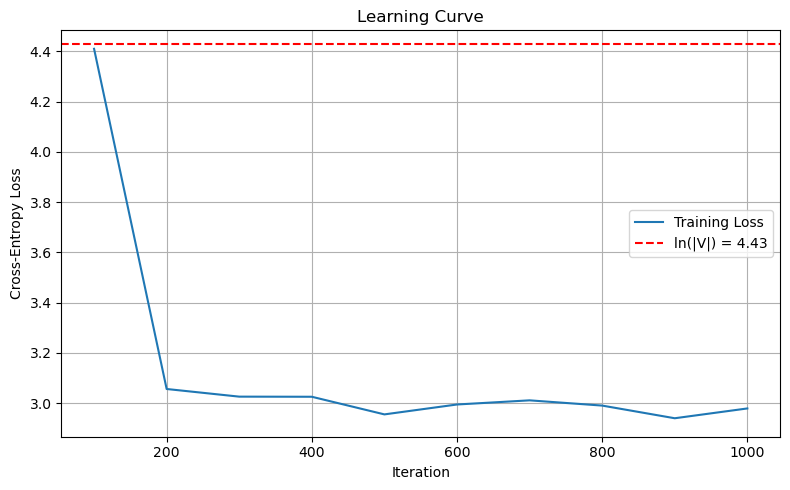

In [19]:
import matplotlib.pyplot as plt
import math

# wired package to solve the kernel crash issue when plotting on jupyter lab
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Plotting learning curve
plt.figure(figsize=(8, 5))
plt.plot(range(log_interval, num_iters + 1, log_interval), loss_history, label="Training Loss")
upper_bound = math.log(vocab_size)
plt.axhline(upper_bound, color='red', linestyle='--', label=f"ln(|V|) = {upper_bound:.2f}")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Question: _Explain your observation._
The plot shows that the training cross-entropy loss starts at around 4.43) and decreases rapidly within the first 200 iterations, this is where the model is learning the 
patterns of the data. It eventually stablized at around 3.0 which is lower than the ln(|V|) upper bound
This could conclude that the model learned the meaningful representation and the context instead of guessing the random output.

### Generating Text
We now write a Code that completes an incomplete text. At this point, we do a minor change: when we want to compute probabilities from the logits, we apply __temperature__ $\theta$ as follows

$$
P(x_{t+1} \vert c_t) = \mathrm{Softmax} ( \frac{\mathrm{logits}}{\theta} )
$$

By setting $\theta= 1$ this reduces to the basic generation. However, we can play with $\theta$ to increase or reduce the randomness of the sampled token.

In [22]:
def generate_text(model, prompt, max_new_tokens, temperature = 1.0):
    '''
    model: trained LM
    prompt: incomplete text
    max_new_tokens: maximum new tokens generated by the model
    temperature: theta in the above formula
    '''
    model.eval()

    # Start with encoded prompt
    context = encode(prompt)[-T:]  # Encode prompt and truncate if too long
    generated = context[:]  # Start with encoded prompt


    for _ in range(max_new_tokens):
        # make input to be a tensor
        x = torch.tensor(generated[-T:], dtype=torch.long, device=device).unsqueeze(0)

        if x.size(1) < T + 1:
            # Pad with dummy tokens (e.g., zeros) to make size T+1
            pad_len = T + 1 - x.size(1)  # Pad length
            x = torch.cat([torch.zeros(1, pad_len, dtype=torch.long, device=device), x], dim=1)  # Left pad with zeros

        with torch.no_grad():
            logits = model(x)  # Get logits (1, T, vocab_size)
            next_token_logits = logits[0, -1]  # Last token's logits

            # Apply temperature
            next_token_logits_with_temp = next_token_logits / temperature

            # find distribution
            probs = F.softmax(next_token_logits_with_temp, dim=-1)

            # Sample from distribution
            next_token = torch.multinomial(probs, num_samples=1).item()


        generated.append(next_token)

    return decode(generated)


Let's now complete a text with only two characters.

In [92]:
prompt = "This is a book. The"
generate_text(model, prompt, 2, temperature=100)

'This is a book. TheÄ!'

### Question: _What do you conclude?_
"The model can generate reasonable continuations from the input prompt and uses learned character-level context to predict likely next characters

### Question: _Play with the temperature. What do you observe? What is your conclusion?_
At low temperature values (0.5<), the model tend to produce more deterministic and predictable outputs, with more repeating common patterns like "II"
With the increase of temperature(>10), the output becomes much more random and less coherent like "Ä!”
Lower temperatures would provide safer, more accurate completion output while higer temperature would become more random and less coherence.

## Programming Question 2: BERT Model and its Fine-tuning
BERT is a well-known transformer-based pre-trained LM. It is mainly used for __text classification__; therefore, it does __not__ have masked decoding. It however give the option to import some tokens as `"[MASK]"` to approximately mimic the masked decoding behavior. In this question, we first import the pre-trained BERT, and use it with Mask to complete a text. In the second part, we take a small subset of IMDB dataset to fine-tune it for text classification and see the impacts of fine-tuning.

### Installing Required Package
Let's first install all we need.


In [3]:
# Install transformers. We can also do it directly at the terminal
%pip install -q datasets transformers

Note: you may need to restart the kernel to use updated packages.


### Text Completion by Masked BERT
Now, let's import BERT. As mentioned, this model does not have masked decoding directly implemented. This means that in each time, the context is computed from both past and future tokens. We can though use the class `BertForMaskedLM` and mimic the masked decoding behavior by replacing unknown tokens with special token `[MASK]`.

In [4]:
from transformers import BertTokenizer, BertForMaskedLM

# Select the device
if torch.backends.mps.is_built():
    device = "mps"
elif torch.backends.cuda.is_built():
    device = "cuda"
else:
    device = "cpu"

# Load pre-trained Tokenizer and the BERT model with masked head
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

model.eval()
model.to(device)

def bert_masked_completion(text, num_masks=5, temperature=1.0):
    '''
    text: incomplete text
    num_masks: indicating number of tokens being added to the text.
    temperature: the temperature by which we sample
    '''
    # Append [MASK] tokens to the incomplete text
    masked_text = text + " " + " ".join(["[MASK]"] * num_masks)
    print("Input Text:", masked_text)

    for i in range(num_masks):
        # Tokenize input
        inputs =  tokenizer(masked_text, return_tensors="pt").to(device)

        # Predict all masked tokens
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits


        # Find the first token [MASK] in the input
        mask_token_index = tokenizer.convert_tokens_to_ids("[MASK]")
        # Save position of the first [MASK]
        mask_pos = inputs['input_ids'][0].tolist().index(mask_token_index)

        # Compute the probability distribution with temperature
        probs = F.softmax(logits[0, mask_pos] / temperature, dim=-1)
        # Sample from the distribution
        predicted_token_id = torch.multinomial(probs, num_samples=1).item()
        predicted_token = tokenizer.decode([predicted_token_id])

        # Replace first [MASK] with predicted token
        tokenized_text = tokenizer.tokenize(masked_text)
        mask_pos_in_tokens = tokenized_text.index("[MASK]")
        tokenized_text[mask_pos_in_tokens] = predicted_token

        # Update masked_text for next iteration
        masked_text = tokenizer.convert_tokens_to_string(tokenized_text)

        print(f"Predicted token at t+{i+1}:", predicted_token)
        print("Current text:", masked_text)

    print("\nFinal completed text:", masked_text)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We now complete a text with this model.

In [6]:
text = "The movie was"
# Example usage
bert_masked_completion(text, num_masks=5)

Input Text: The movie was [MASK] [MASK] [MASK] [MASK] [MASK]
Predicted token at t+1: dubbed
Current text: the movie was dubbed [MASK] [MASK] [MASK] [MASK]
Predicted token at t+2: as
Current text: the movie was dubbed as [MASK] [MASK] [MASK]
Predicted token at t+3: tributary
Current text: the movie was dubbed as tributary [MASK] [MASK]
Predicted token at t+4: film
Current text: the movie was dubbed as tributary film [MASK]
Predicted token at t+5: .
Current text: the movie was dubbed as tributary film .

Final completed text: the movie was dubbed as tributary film .


### Question: _Play around with the temperature. What do you see?_
Similar to our LM, with lower temperature ( 0.5< ), the output is more deterministic and coherence and each time the generated result is the same
With higher temerpature(>2), the output would become more random and more diverse even have some error in the generated text.
Temperature is related to the balance between diversity and coherence in text generation.

### Pre-trained BERT for Classification
We next fine-tune the model `BertForSequenceClassification` for text classification. To this end, we use a small subset of the `"imdb"` dataset. Let's first build the data.

In [9]:
pip install -U datasets

In [10]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Sample one example
print(dataset["train"][10])


# Sample a small subset of D_train samples for training and D_test for testing
D_train, D_test = 1000, 500
small_train_dataset = dataset["train"].shuffle().select(list(range(D_train)))
small_test_dataset = dataset["test"].shuffle().select(list(range(D_test)))

{'text': 'It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn\'t go on to star in more and better films. Sadly, I didn\'t think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is a

For tokenization, we use `BertTokenizerFast` as it helps us process faster.

In [12]:
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test = small_test_dataset.map(tokenize_function, batched=True)

# Show tokenized sample
print(tokenized_train[0])

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'text': "Yes, it's over the top, yes it's a bit clichéd and yes, Constance Marie is a total babe and worthy of seeing again and again! The jokes and gags might get old and repetitive after a while but the show's still fun to watch. Since it's a family show the humour is toned down and the writers have incorporated family values and ideals in between the gags.<br /><br />George Lopez is funny. Don't take him seriously and the show's a winner. I'm sure he didn't intend his character to be serious or a paragon of virtue. His outbursts and shouts of glee are hilarious...<br /><br />I do have to say that the one big, dark, bitter spot is Benny. I hate the character...so much so that anytime she's on for more than 30 seconds I mute the TV just so I don't have to hear her. There is nothing funny about her dialogue or her jokes. As a mother she has to be the worst out there and I am just shocked and surprised that George, as the character, would stand by such a deplorable person for so long.<

We next test the pre-trained model on the test set to see its pre-trained performance.

In [14]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Create a DataLoader for test set
test_dataloader = DataLoader(tokenized_test, batch_size=16)

# Move model to device at eval mode
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)
model.eval()


# Set counter for number of correct prediction
correct = 0
total = 0

# No gradient calculation needed during evaluation
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # compute context
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Find the class with "maximum" logit
        predictions = torch.argmax(outputs.logits, dim=1)

        # compute number of correct predictions
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Compute accuracy
accuracy = correct / total
print(f"Pretrained BERT accuracy on test set: {accuracy:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 32/32 [00:04<00:00,  7.89it/s]

Pretrained BERT accuracy on test set: 0.4820


### Fine-tuning BERT
We now fine-tune BERT on the train dataset. We use __Selective Fine-tuning,__ where we only fine-tune the last encoder (transformer) layer and the final MLP (classification head). We can freeze all other layers using the following code.

In [16]:
# Freeze all BERT parameters
for param in model.bert.parameters():
    param.requires_grad = False

# Unfreeze only the last encoder layer
last_layer_idx = 11
for param in model.bert.encoder.layer[last_layer_idx].parameters():
    param.requires_grad = True

# Also unfreeze the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True


For fine-tuning, we use __LoRA__ algorithm with rank $\ell=8$. This can be directly implemented using the `pfet` library. The following code builds the required configurations.

In [18]:
from peft import get_peft_model, LoraConfig, TaskType

# LoRA config — tune the hyperparameters as you wish
lora_config = LoraConfig(
    r = 8
    ,               # rank of LoRA, i.e., l in the lecture-notes
    lora_alpha = 32,     # scaling factor
    target_modules = ["query", "value"],  # target attention modules for LoRA
    lora_dropout = 0.1,
    bias = "none",
    task_type = TaskType.SEQ_CLS,
)

# Apply LoRA to the model -> This will apply LoRA to unfrozen layers
model = get_peft_model(model, lora_config)

We can readily perform the fine tuning using the `Trainer` class. The following code defines the `trainer` which can be used to fine-tune the model over our dataset. We set the the number of fine-tuning epochs to 3.

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",        # <-- add this line
    learning_rate=5e-4,
    per_device_train_batch_size = 16 #set it to the batch-size of the dataloader
    ,
    per_device_eval_batch_size = 16
    ,
    num_train_epochs= 3
    ,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)


# The tokenized_train and tokenized_test datasets must have format set for torch tensors:
# tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


We can now fine-tune easily by applying method `.train()` to the `trainer`.

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.437900,0.698409
2,0.230300,0.353533
3,0.231400,0.418474


TrainOutput(global_step=189, training_loss=0.3540948168941276, metrics={'train_runtime': 68.413, 'train_samples_per_second': 43.851, 'train_steps_per_second': 2.763, 'total_flos': 396032624640000.0, 'train_loss': 0.3540948168941276, 'epoch': 3.0})

### Question: _Play around with the learning rate at `training_args` to see the impact. Report what you see._
**Training with 3 epochs**



Learning_rate: 5e-3
training_loss: 0.696700
validation_loss: 0.694025

Learning_rate: 5e-6
training_loss: 0.683400
validation_loss: 0.693107

Learning_rate: 5e-5
training_loss: 0.664300
validation_loss: 0.657781

**Learning_rate: 5e-4**
training_loss: 0.231400
validation_loss: 0.418474

Learning rate at 5e-4 is the best model with the lowest validation loss, as it provides a good balance between learning speed and generalization, even though there are existence of overfitting
A higher rate (5e-3) leads to unstable training, while lower rate (5e-6) has slow convergence.

Let's now evaluate the fine-tuned model.

In [37]:
# Set model back to eval
model.eval()

# Set prior values
correct = 0
total = 0

# evaluation loop
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # compute context
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Find the class with "maximum" logit
        predictions = torch.argmax(outputs.logits, dim=1)

        # compute number of correct predictions
        correct += (predictions == labels).sum().item() # COMPLETE # add the number of correct classifications
        total += labels.size(0) # COMPLETE # update total number of samples

# Compute accuracy
accuracy = correct / total
print(f"Fine_tuned BERT accuracy on small test set: {accuracy:.4f}")


100%|██████████| 32/32 [00:04<00:00,  7.69it/s]

Fine_tuned BERT accuracy on small test set: 0.8500


### Question: _Compare the fine-tuned accuracy to that of the pre-trained one. What do you conclude?_
The fine-tuned model acheieved an obviously higer accuracy(0.85) than the pre-trained model on imdb dataset(0.48).
We could conclude that the selective fine-tuning with lora could siginificantly improve the performance 